In [1]:
import csv
import math as m
from random import uniform as unif
import networkx as nx
import pandas as pd
import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
expid = "./exp1_run9"

In [3]:
if not os.path.exists(expid):
    os.makedirs(expid)

# Problem instance

## Geographic data

In [4]:
from pkg.read_problem import read_problem, extract_problem

In [5]:
xy_customers, xy_icps, xy_crcs, xy_pc, q = read_problem('./datasets/original')

In [6]:
xy_icps = xy_icps + [[unif(20,100),unif(20,70)] for i in range(15)]
xy_crcs = xy_crcs + [[unif(20,100),unif(20,70)] for i in range(10)]

In [7]:
I,J,C,B,K,V,W,DcUj,Dcj,Dc,FCV,FCT,FCR,U = extract_problem(xy_customers, xy_icps, xy_crcs, xy_pc, q)

## Capacity constraints

In [8]:
Q = [200 for j in range(J)]
V = [[200 for j in range(J)],[800 for c in range(C)]]

## Adapting costs

In [9]:
# two-level cost
FCRD = []
for c in range(C):
    FCRD.append(FCR[c] + Dc[c])

f = FCT+FCRD
c = [[[W[i][j1] + Dcj[j1][j2] for j2 in range(C)] for j1 in range(J)] for i in range(I)]

# Plot Problem

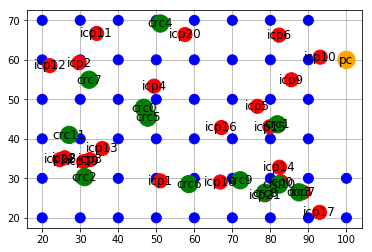

In [10]:
from pkg.lrp_nodes_graph import lrp_nodes_graph, lrp_draw_and_save
G, pos, labels, colors, size = lrp_nodes_graph(xy_customers, xy_icps, xy_crcs, xy_pc)

lrp_draw_and_save(G, pos, labels, colors, size, expid+"/problem.png")

# Define Functions

## run_uflp_cplex

In [11]:
def run_uflp_cplex(G,I,J,W,FCT,expid):
    from pkg.uflp_cplex import uflp_cplex

    prob, Y, N_icp = uflp_cplex(I,J,
                W,FCT,
                relaxation=False,path=expid+"/uflp_cplex.lp")

    G2 = G.copy()

    for j,vj in enumerate(Y):
        for i,vi in enumerate(vj):
            if vi == 1:
                G2.add_edge(I+i,j)

    lrp_draw_and_save(G2, pos, labels, colors, size, expid+"/uflp_cplex.png")

## run_cflp_cplex

In [12]:
def run_cflp_cplex(G,I,J,W,FCT,U,Q,expid):
    from pkg.cflp_cplex import cflp_cplex

    prob, Y, N_icp = cflp_cplex(I,J,
                W,FCT,U,Q,
                relaxation=False,path=expid+"/cflp_cplex.lp")

    G2 = G.copy()

    for j,vj in enumerate(Y):
        for i,vi in enumerate(vj):
            if vi == 1:
                G2.add_edge(I+i,j)

    lrp_draw_and_save(G2, pos, labels, colors, size, expid+"/cflp_cplex.png")

## run_pm_flp_cplex

In [13]:
def run_pm_flp_cplex(G,I,J,W,p,expid):
    from pkg.pm_flp_cplex import pm_flp_cplex

    prob, Y, N_icp = pm_flp_cplex(I,J,
                W,p,
                relaxation=False,path=expid+"/pm_flp_cplex.lp")

    G2 = G.copy()

    for j,vj in enumerate(Y):
        for i,vi in enumerate(vj):
            if vi == 1:
                G2.add_edge(I+i,j)

    lrp_draw_and_save(G2, pos, labels, colors, size, expid+"/pm_flp_cplex.png")

## run_tuflp_cplex

In [14]:
def run_tuflp_cplex(G,I,J,C,c,f,expid):
    from pkg.tuflp_cplex import tuflp_cplex

    prob, X, Z = tuflp_cplex(I,J,C,c,f,
                relaxation=False,path=expid+"/tcflp_cplex.lp")


    G2 = G.copy()

    for i in range(I):
        for j1 in range(J):
            for j2 in range(C):
                if X[i][j1][j2] == 1:
                    G2.add_edge(i,I+j1)

    lrp_draw_and_save(G2, pos, labels, colors, size, expid+"/tcflp_cplex.png")

## run_tecflp_cplex

In [15]:
def run_tecflp_cplex(G,I,J,C,c,f,q,V,expid):
    from pkg.tecflp_cplex import tecflp_cplex

    prob, X, Z = tecflp_cplex(I,J,C,c,f,q,V,
                relaxation=False,path=expid+"/tecflp_cplex.lp")

    G2 = G.copy()

    for i in range(I):
        for j1 in range(J):
            for j2 in range(C):
                if X[i][j1][j2] == 1:
                    G2.add_edge(i,I+j1)

    lrp_draw_and_save(G2, pos, labels, colors, size, expid+"/tecflp_cplex.png")

## run_crab_mb_m_cplex

In [16]:
def run_crab_mb_m_cplex(I,J,C,B,K,V,
            w,Dcj,FCV,FCT,FCR,Dc,q,
            Q, expid):
    from pkg.crab_mb_m_cplex import crab_mb_m_cplex

    prob, Y, Z, N, V = crab_mb_m_cplex(I,J,C,B,K,V,
            w,Dcj,FCV,FCT,FCR,Dc,q,
            Q, relaxation=False,path=expid+"/crab_mb_m_cplex.lp")
    
    print(prob.solution.get_objective_value())

    G2 = G.copy()

    for i in range(I):
        for j in range(J):
                if Y[i][j] == 1:
                    G2.add_edge(i,I+j)

    lrp_draw_and_save(G2, pos, labels, colors, size, expid+"/crab_mb_m_cplex.png")
    
    print(["Z_" + str(c) + "_" + str(j) + "_" + str(b) for c in range(C+J) for j in range(C+J) for b in range(B) if Z[c][j][b] >= 1])
    
    return prob, Y, Z, N, V

# Run experiment

1 loop, best of 1: 330 ms per loop


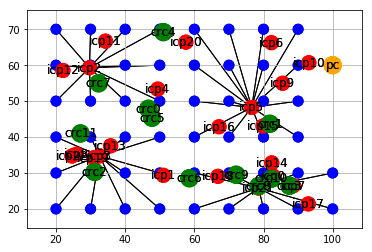

In [17]:
result1 = %timeit -r 1 -o run_uflp_cplex(G,I,J,W,FCT,expid)

1 loop, best of 1: 5.55 s per loop


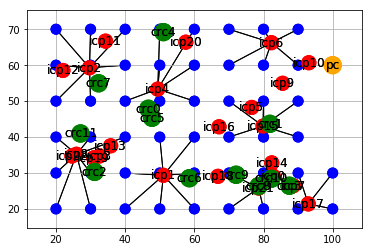

In [18]:
result2 = %timeit -r 1 -o run_cflp_cplex(G,I,J,W,FCT,U,Q,expid)

1 loop, best of 1: 235 ms per loop


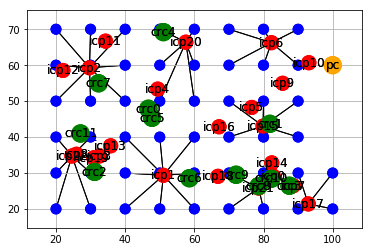

In [19]:
result3 = %timeit -r 1 -o run_pm_flp_cplex(G,I,J,W,8,expid)

1 loop, best of 1: 1.08 s per loop


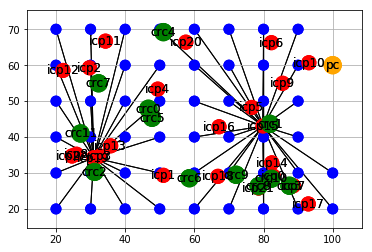

In [20]:
result4 = %timeit -r 1 -o run_tuflp_cplex(G,I,J,C,c,f,expid)

1 loop, best of 1: 52.8 s per loop


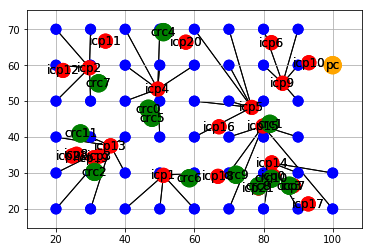

In [21]:
result5 = %timeit -r 1 -o run_tecflp_cplex(G,I,J,C,c,f,U,V,expid)

1058 1058 1058


Default row names c1, c2 ... being created.


Tried aggregator 1 time.
MIP Presolve eliminated 24 rows and 2051 columns.
MIP Presolve modified 23 coefficients.
Reduced MIP has 1034 rows, 13892 columns, and 47518 nonzeros.
Reduced MIP has 13869 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.05 sec. (31.75 ticks)
Tried aggregator 1 time.
Reduced MIP has 1034 rows, 13892 columns, and 47518 nonzeros.
Reduced MIP has 13869 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (19.73 ticks)
Probing time = 0.03 sec. (6.65 ticks)
Clique table members: 28069.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.06 sec. (25.71 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

      0     0     1151.3539    66                   1151.3539      477         
      0     0     1266.4132   140  

Default row names c1, c2 ... being created.


Tried aggregator 1 time.
MIP Presolve eliminated 24 rows and 2051 columns.
MIP Presolve modified 23 coefficients.
Reduced MIP has 1034 rows, 13892 columns, and 47518 nonzeros.
Reduced MIP has 13869 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.08 sec. (31.75 ticks)
Tried aggregator 1 time.
Reduced MIP has 1034 rows, 13892 columns, and 47518 nonzeros.
Reduced MIP has 13869 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.05 sec. (19.73 ticks)
Probing time = 0.06 sec. (6.65 ticks)
Clique table members: 28069.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.08 sec. (25.71 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

      0     0     1151.3539    66                   1151.3539      477         
      0     0     1266.4132   140  

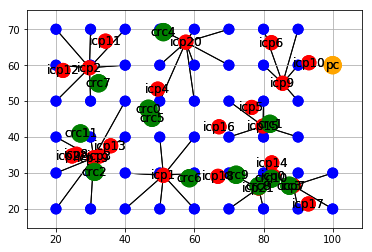

In [22]:
result6 = %timeit -r 1 -o sprob, sY, sZ, sN, sV = run_crab_mb_m_cplex(I,J,C,B,K,V,W,DcUj,FCV,FCT,FCR,Dc,U,V,expid)

In [23]:
print(sV,sN)

NameError: name 'sV' is not defined

In [ ]:
# FCT

## Results

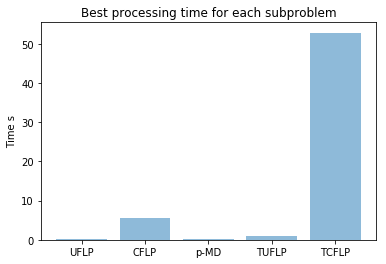

In [25]:
objects = ('UFLP', 'CFLP', 'p-MD','TUFLP', 'TCFLP')
y_pos = np.arange(len(objects))
performance = [result1.best,result2.best,result3.best,result4.best,result5.best]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Time s')
plt.title('Best processing time for each subproblem')
plt.savefig(expid+"/expid.png", format="PNG") 
plt.show()